In [70]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
dirname = os.getcwd()
csv_path = os.path.join(dirname, 'stock_data.csv')
print(csv_path)

/Users/JakeWu-Chen/Downloads/Projects/StockNN_to_SpringAPI/stock_data.csv


## Data Preprocessing

### Data Cleaning

In [71]:
#getting data for stocks
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
data = yf.download(stocks, start="2018-01-01", end="2024-01-01", interval="1d")


[*********************100%***********************]  5 of 5 completed


In [72]:
print("Data Preview:")
print(data.head())

Data Preview:
Price                      Adj Close                                   \
Ticker                          AAPL       AMZN      GOOGL       MSFT   
Date                                                                    
2018-01-02 00:00:00+00:00  40.568935  59.450500  53.527958  79.792892   
2018-01-03 00:00:00+00:00  40.561867  60.209999  54.441196  80.164276   
2018-01-04 00:00:00+00:00  40.750271  60.479500  54.652668  80.869820   
2018-01-05 00:00:00+00:00  41.214233  61.457001  55.377377  81.872459   
2018-01-08 00:00:00+00:00  41.061142  62.343498  55.572891  81.956001   

Price                                    Close                        \
Ticker                         NVDA       AAPL       AMZN      GOOGL   
Date                                                                   
2018-01-02 00:00:00+00:00  4.930221  43.064999  59.450500  53.660500   
2018-01-03 00:00:00+00:00  5.254698  43.057499  60.209999  54.576000   
2018-01-04 00:00:00+00:00  5.282397  43.2

In [73]:
#data cleaning to ensure there are no:
# missing values from holidays/weekends
# Ensure all dates are in UTC
# remove duplicates

# Summary statistics for each column
print("Summary Statistics:")
print(data.describe())

#Use mean and median tto guage the quality of data or if its skewed. (if mean is significantly higher or lower than the median)
#Higher standard deviation means higher volatility
#Use percentiles to show what typical vs extreme prices look like over time

# check for missing values
missing_data = data.isnull().sum()
print("\nMissing vals")
print(missing_data[missing_data > 0]) #print the data in columns only if its greater than 1
#there are no missing values (skip this part Jake)

Summary Statistics:
Price     Adj Close                                                      \
Ticker         AAPL         AMZN        GOOGL         MSFT         NVDA   
count   1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean     108.431235   120.070903    90.966566   207.914876    15.729655   
std       51.220748    33.408177    31.271053    83.786301    12.231726   
min       33.989906    59.450500    49.111893    78.920242     3.151646   
25%       51.525799    90.698997    60.072254   128.783829     5.964213   
50%      121.142693   114.302002    87.802582   215.288086    13.119002   
75%      151.066208   154.474503   119.404335   277.285187    21.227779   
max      197.361084   186.570496   149.468399   380.619812    50.393753   

Price         Close                                                      ...  \
Ticker         AAPL         AMZN        GOOGL         MSFT         NVDA  ...   
count   1509.000000  1509.000000  1509.000000  1509.000000  1509.0000

Initial thoughts:
MSFT has the highest volatility, but also has the higherst numbers across the board which might not mean its mroe volatile just that all of its numbers are more widely spread across.
NVDA seems to be the most static and stable, AMZN seems to be the best overall since it has a stable growth and low volatility, but is also worth a lot


MSFT (Microsoft):

Observation: Highest mean and maximum values among the stocks.
Volatility: High standard deviation, indicating greater price variability over time.
Insight: Reflects a strong market position but with notable price fluctuations, making it more volatile.

NVDA (NVIDIA):

Observation: Lower mean and max prices compared to other stocks.
Volatility: Lowest standard deviation, suggesting a more consistent price range.
Insight: Indicates stability with less dramatic swings, appealing for investors prioritizing steadiness.

AMZN (Amazon):

Observation: Moderate mean value with a balanced growth profile.
Volatility: Relatively low standard deviation, reflecting stable growth.
Insight: Balances growth with stability, offering steady returns with lower risk.

AAPL (Apple):

Observation: Consistently high mean and median prices, showing sustained growth over time.
Volatility: Moderate standard deviation, indicating relatively balanced price changes.
Insight: AAPL’s performance highlights it as a reliable growth stock, providing consistent returns. It offers both stability and moderate growth potential, making it suitable for long-term investors seeking both growth and reliability.

GOOGL (Alphabet):

Observation: Mean and median prices fall between AAPL and NVDA, suggesting moderate but steady growth.
Volatility: Moderate standard deviation, similar to AAPL, showing controlled price fluctuations.
Insight: GOOGL exhibits stable growth with manageable volatility. Its balanced profile appeals to investors looking for steady returns without high volatility, particularly in the tech sector.

High Variability (e.g., MSFT) may appeal to investors with higher risk tolerance.
Stability (e.g., NVDA) is valuable for more conservative investments.
Balanced Growth (e.g., AAPL, AMZN, GOOGL) provides steady returns, ideal for long-term, low-risk investment strategies.

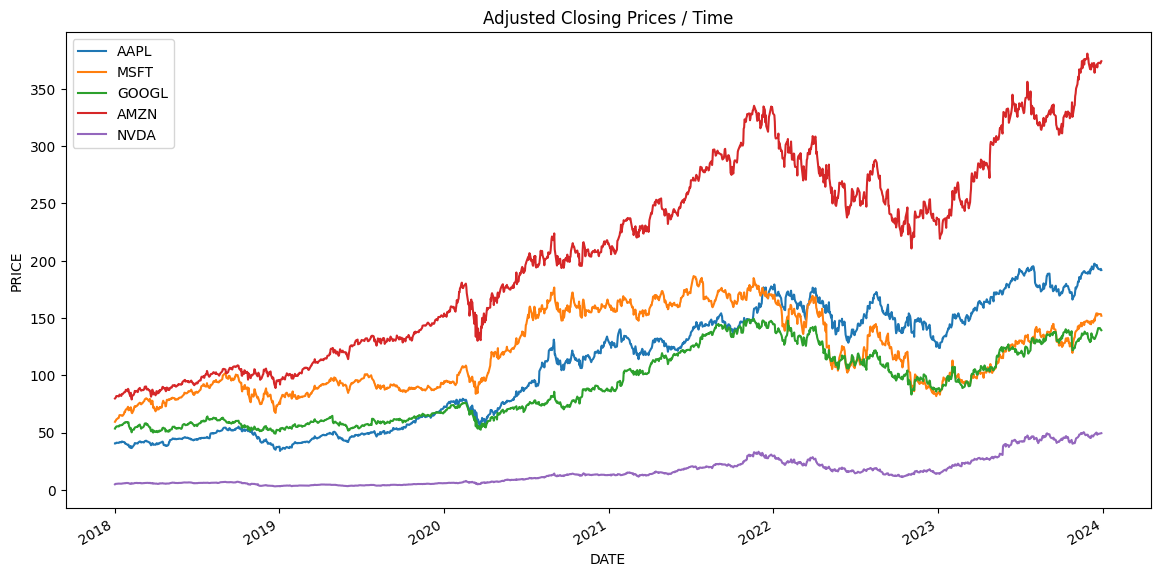

In [74]:
data['Adj Close'].plot(figsize=(14, 7), title="Adjusted Closing Prices / Time")
plt.xlabel("DATE")
plt.ylabel("PRICE")
plt.legend(stocks)
plt.show()

### Feature Engineering

In [75]:
# Calculating the percentage change to see how a stock's price has increased or decreased in value
for stock in stocks:
    # Use correct formatting
    data[('Pct Change', stock)] = data['Adj Close'][stock].pct_change()

# Calculating moving averages to see trends without short-term fluctuations 
# Calculate moving averages
for stock in stocks:
    data[('MA_5', stock)] = data['Adj Close'][stock].rolling(window=5).mean()
    data[('MA_20', stock)] = data['Adj Close'][stock].rolling(window=20).mean()
    data[('MA_50', stock)] = data['Adj Close'][stock].rolling(window=50).mean()

# Calculate volatility using the percentage change
for stock in stocks:
    # Ensure the percentage change column exists before calculating volatility
    if ('Pct Change', stock) in data.columns:
        data[('Volatility', stock)] = data[('Pct Change', stock)].rolling(window=30).std()

# Calculating the volume moving average and spikes
for stock in stocks:
    data[('Volume MA', stock)] = data['Volume'][stock].rolling(window=20).mean()
    data[('Volume Spike', stock)] = data['Volume'][stock] > (data[('Volume MA', stock)] * 1.5)  # Days with volume significantly higher than mean

# Drop any rows with NaN values resulting from the rolling calculations
data.dropna(inplace=True)

print(data.head())


data.to_csv(csv_path)


Price                      Adj Close                                   \
Ticker                          AAPL       AMZN      GOOGL       MSFT   
Date                                                                    
2018-03-14 00:00:00+00:00  42.195724  79.550003  57.302608  87.536278   
2018-03-15 00:00:00+00:00  42.245384  79.115997  57.388393  87.844093   
2018-03-16 00:00:00+00:00  42.096401  78.584000  56.580898  88.235809   
2018-03-19 00:00:00+00:00  41.453201  77.246498  54.867638  86.640854   
2018-03-20 00:00:00+00:00  41.439022  79.325500  54.654667  86.864716   

Price                                    Close                        \
Ticker                         NVDA       AAPL       AMZN      GOOGL   
Date                                                                   
2018-03-14 00:00:00+00:00  6.155530  44.610001  79.550003  57.444500   
2018-03-15 00:00:00+00:00  6.170379  44.662498  79.115997  57.530499   
2018-03-16 00:00:00+00:00  6.198591  44.505001  78.5840

In [76]:
names = ['NVDA', 'AMZN', 'GOOGL', 'MSFT', 'AAPL']
types = ['']
def choose_stock(name:str, type:str):
    return data[(type, name)]

print(choose_stock('NVDA', 'Close').head(5))

Date
2018-03-14 00:00:00+00:00    6.2185
2018-03-15 00:00:00+00:00    6.2335
2018-03-16 00:00:00+00:00    6.2620
2018-03-19 00:00:00+00:00    6.0250
2018-03-20 00:00:00+00:00    6.2395
Name: (Close, NVDA), dtype: float64
